In [148]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Conv1D, MaxPool1D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MSE
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import he_normal, glorot_uniform
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from visualization_utility import plot_data
from NN_model_plots import plot_learning_curve, plot_random, plot_relative_errors, plot_errors_hist
import h5py
import os
import sys

In [2]:
print(tf.__version__)

2.15.0


**STEP 1:**
- Load the data.

**STEP 2:**
- Due to some numerical errors in spherical albedo, it has to be handled properly. We will **interpolate** all the **NaN** values. For this reason as well, we will not use the [prepare_NN_data](https://github.com/monsieurformule/SummerProject/blob/main/code-files/prepare_NN_data.ipynb) script to preprocess the data like with all the other emulators. Instead, the preprocessing will be performed here in this separate script.

**STEP 3:**
- Spherical albedo also contains some high spikes that are likely numerical errors. To deal with these errors, we'll follow the instructions on the image below.

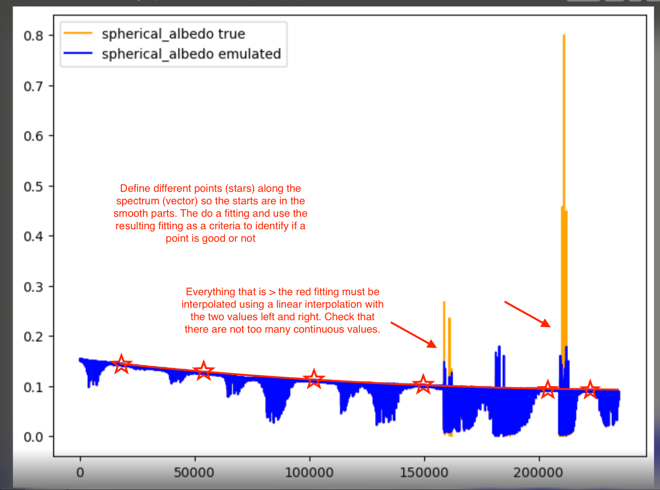

In [183]:
from PIL import Image
with Image.open("SA_numerical_errors.png") as im:
    resized_img = im.resize((int(im.width / 2), int(im.height / 2)))
    resized_img.show()

<h3>Step 1: load the data</h3>

In [15]:
# Path to the input data
input_data_path = "/fmi/projappl/project_2001985/jamin/data/libradtran_data/NN_data/inputs.csv"

In [16]:
X = pd.read_csv(input_data_path, index_col=0)

In [17]:
X.head(1)

,atmosphere_file,sza,altitude,tau,2e-05,4e-05,6e-05,0.00012,0.00026,0.00062,...,324.0,372.0,426.0,487.0,554.0,628.0,710.0,802.0,902.0,1013.0
0,afglms_Q1_0,25.0,0.0,0.05,248.7303,248.7303,248.7303,248.7303,248.7303,248.7303,...,215.0723,220.1957,225.84,232.0706,237.8445,243.4155,248.4294,252.3007,253.4411,249.7135


In [18]:
# Drop the identifier column
X = X.drop("atmosphere_file", axis=1).values

In [19]:
X.shape

(1728, 53)

In [20]:
# One output matrix (to get the column names of the output data)
output1 = pd.read_json("/fmi/projappl/project_2001985/jamin/data/libradtran_data/NN_data/output_params/afglms_Q1_0_sza25_vza1.0_phi0_phi00_alt0_tau0.05.json")

In [21]:
output1.head(1)

,wavelength,rho0,rho1,rho2,tdir_down,tdif_down,tdir_up,tdif_up,spherical_albedo,edir,edif,path_rad,albedo1,albedo2
0,500.001,0.059788,0.185492,0.272199,0.782454,0.119322,0.800646,0.10874,0.133944,1560.855731,238.026869,37.963658,0.15,0.25


In [23]:
output_col_indices = {col_name: idx for idx, col_name in enumerate(output1)}
output_col_indices

{'wavelength': 0,
 'rho0': 1,
 'rho1': 2,
 'rho2': 3,
 'tdir_down': 4,
 'tdif_down': 5,
 'tdir_up': 6,
 'tdif_up': 7,
 'spherical_albedo': 8,
 'edir': 9,
 'edif': 10,
 'path_rad': 11,
 'albedo1': 12,
 'albedo2': 13}

In [24]:
# Path to the (full) output data
full_output_data_path = "/fmi/projappl/project_2001985/jamin/data/libradtran_data/NN_data/outputs_full.h5"

In [25]:
def load_HDF5(path: str):
    with h5py.File(name=path, mode="r") as hf:
        data = hf["output_data"][:]
    return data

In [26]:
Y = load_HDF5(full_output_data_path)

In [27]:
Y.shape

(1728, 235002, 14)

In [28]:
spherical_albedo = Y[:, :, output_col_indices["spherical_albedo"]]

In [29]:
spherical_albedo.shape

(1728, 235002)

In [30]:
type(spherical_albedo)

numpy.ndarray

In [31]:
np.isnan(spherical_albedo).any()

True

- As expected, spherical albedo contains missing values.

In [38]:
print(f"Range of spherical_albedo: [{np.min(spherical_albedo[~np.isnan(spherical_albedo)])}, {np.max(spherical_albedo[~np.isnan(spherical_albedo)])}]")

Range of spherical_albedo: [-20.0919540276, 4.0]


In [39]:
np.sum(np.isnan(spherical_albedo))

843161

In [40]:
(np.sum(np.isnan(spherical_albedo)) / spherical_albedo.size) * 100

0.2076324429232596

- 0.2% of the values are NaN.

<h3>Step 2: first interpolation</h3>

In [41]:
# Set the values outside the range [0, 1] to NaN
spherical_albedo[(spherical_albedo < 0) | (spherical_albedo > 1)] = np.nan

# Interpolate NaNs for each row
for i in range(spherical_albedo.shape[0]):
    row = spherical_albedo[i, :]
    nans = np.isnan(row)
    if np.any(~nans):    # interpolate only if there are valid non-NaN values to interpolate on
        row[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), row[~nans])

- 'nans' is a boolean array that is True where the values in 'row' are NaN, and False where the values in 'row' are not NaN. 

- np.flatnonzero(nans) returns the indices of the elements in 'row' that are NaN.

- np.flatnonzero(~nans) returns the indices of the elements in 'row' that not NaN.

- row[~nans] selects the elements in 'row' that are not NaN.

- row[nans] selects the elements in 'row' that are NaN.

$\quad \boldsymbol{\rightarrow} \quad \text{row[nans] = np.interp(x, xp, fp) interpolates the NaN values.}$

**np.interp(x, xp, fp)**

- **x:** the x-coordinates (indices of the NaN values) where interpolation is to be performed (i.e., where NaNs are located)

- **xp:** the x-coordinates of the data points (i.e., the indices of the valid non-NaN values)

- **fp:** the y-coordinates of the data points (i.e., the actual values of these valid points)

In [42]:
np.isnan(spherical_albedo).any()

False

- NaNs are gone.

In [43]:
print(f"Range: [{np.min(spherical_albedo[~np.isnan(spherical_albedo)])}, {np.max(spherical_albedo[~np.isnan(spherical_albedo)])}]")

Range: [0.0, 0.9999999997000001]


<h3>Step 3: following the instructions on the graph</h3>

In [212]:
def plot_random_spectra(Y):
    if not isinstance(Y, np.ndarray):
        Y = Y.numpy()
    random_idx = random.randint(0, Y.shape[0])
    plt.plot(np.arange(Y.shape[1]), Y[random_idx, :], color="blue")
    plt.title(f"Random spectra at index position {random_idx}");

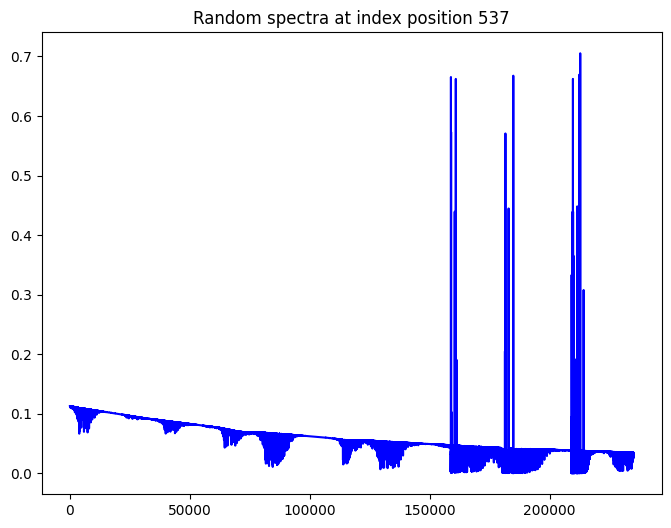

In [214]:
plt.figure(figsize=(8,6), dpi=100)
plot_random_spectra(spherical_albedo)

In [209]:
def plot_full_spectra(Y):
    if not isinstance(Y, np.ndarray):
        Y = Y.numpy()
    Y = Y.ravel()
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    ax.plot(np.arange(len(Y)), Y, color="blue")
    ax.set_title("Full spectra");

- Puhti won't plot this due to large size (5.7 billion elements) of spherical albedo.

In [46]:
(np.sum(spherical_albedo > 0.3) / spherical_albedo.size) * 100

0.024249695116857952

In [47]:
(np.sum(spherical_albedo > 0.4) / spherical_albedo.size) * 100

0.015133834952389688

In [48]:
(np.sum(spherical_albedo > 0.5) / spherical_albedo.size) * 100

0.008389901015814837

- The range of spherical albedo is $\, [0, 1], \,$ but only a small fraction of the values are larger than 0.3 (this is also visible in the graph in the beginning of the notebook). These values are likely numerical errors.

**Selecting smooth regions**

In [124]:
def gather_values(x, idx: int):
    """
    Gathers values from a specific index location across all the samples
    to detect if the region is smooth. 
    After the values have been gathered, this function plots the values to see their distribution.
    
    Args:
    x -- an array (spherical_albedo)
    idx -- the index location where to gather the values from across all the samples
    
    Returns:
    None.
    """
    num_samples = x.shape[0]
    vals = []
    for sample in range(num_samples):
        vals.append(x[sample, idx])
        
    ##### Plotting #####
    smallest = str(np.round(np.min(vals), 3))
    largest = str(np.round(np.max(vals), 3))
    median = str(np.round(np.median(vals), 3))
    mean = str(np.round(np.mean(vals), 3))
    plt.figure(figsize=(8,6), dpi=100)
    sns.violinplot(vals)
    plt.annotate(f"min val: {smallest}\nmax val: {largest}\nmedian: {median}\nmean: {mean}", 
                 xy=(1,1), 
                 xycoords="axes fraction", 
                 xytext=(-10, -10),
                 textcoords="offset points",
                 ha="right",
                 va="top")
    plt.title(f"Values gathered from the index {idx}")
    plt.show();

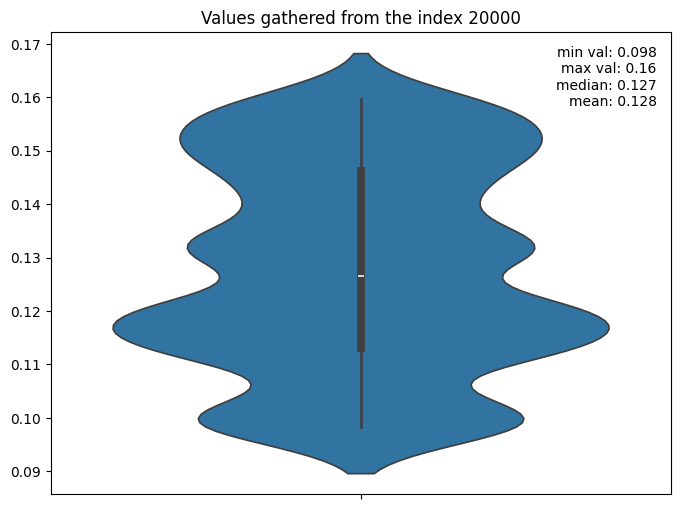

In [125]:
gather_values(x=spherical_albedo, idx=20000)

If the violin plot is not familiar to the reader, here are few clarifications:

- A violin plot is similar to a box plot, but also includes the density of the data.
- In a violin plot, the width of the "violin" at any given y-value indicates the density of the data point at that value.
- Wider sections of the violin plot represent regions where more data points are concentrated (this indicates that many samples have similar values).
- Narrower sections indicate regions where fewer data points are located, meaning that fewer samples have value in that range.

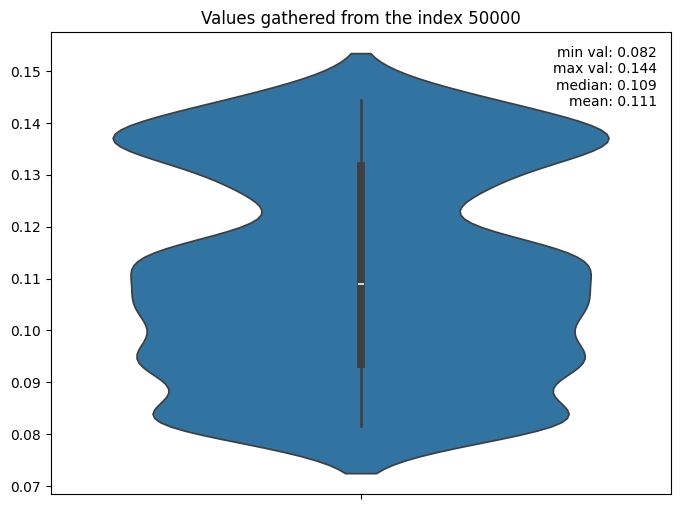

In [126]:
gather_values(x=spherical_albedo, idx=50000)

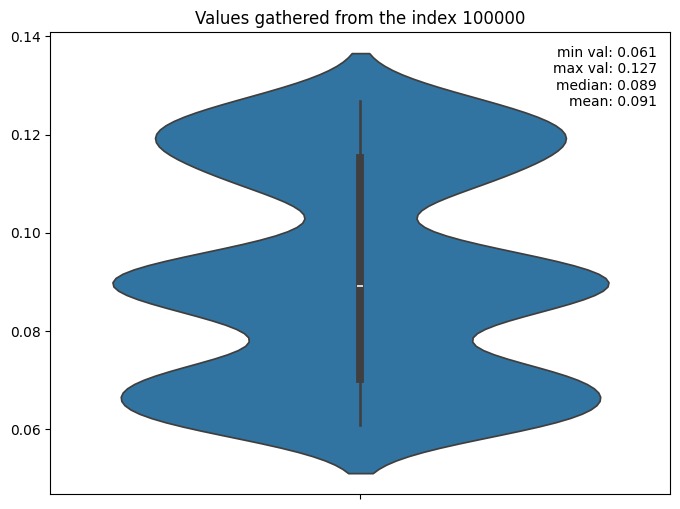

In [127]:
gather_values(x=spherical_albedo, idx=100000)

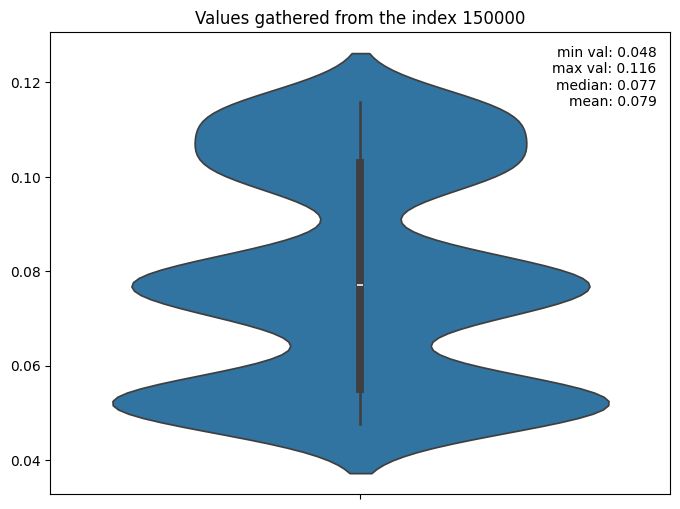

In [128]:
gather_values(x=spherical_albedo, idx=150000)

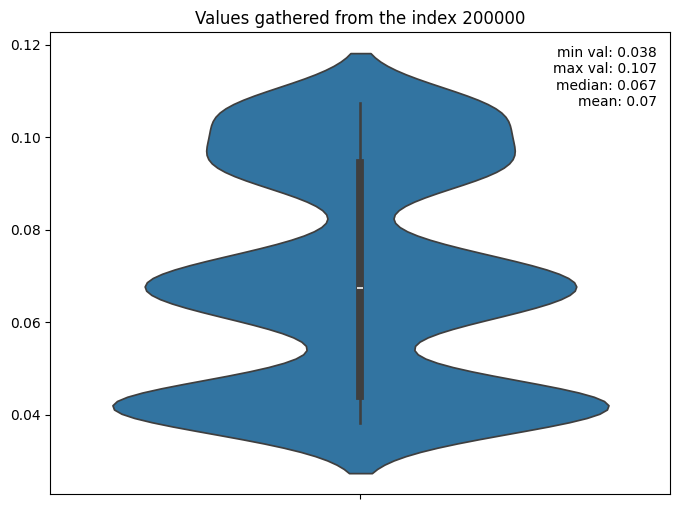

In [129]:
gather_values(x=spherical_albedo, idx=200000)

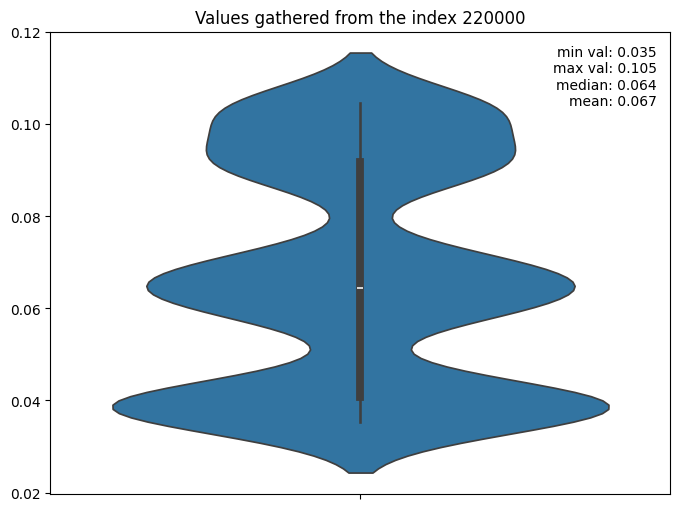

In [130]:
gather_values(x=spherical_albedo, idx=220000)

- It seems that the indices $\, [20000, 50000, 100000, 150000, 200000, 220000] \,$ could serve as the smooth point indicators in the spectrum.

**Fit a polynomial line**

In [229]:
def bye_errors(SA):
    """
    Docstring here.
    
    Args:
    SA -- a NumPy array (spherical albedo)
    
    Returns:
    ---
    
    Notes
    - curve_fit finds the best-fit parameters for the polynomial model 
      based on the smooth data points provided ('smooth_x', 'smooth_y').
    - poly3 then uses these best-fit parameters to compute the y-values 
      of the fitted polynomial model across the entire range of x.
    """
    # A third degree polynomial fit
    def poly3(x, a, b, c, d):
        return a*x**3 + b*x**2 + c*x + d
    
    # The number of samples
    num_samples = SA.shape[0]
    
    # Indices of the smooth points (these are the same for each sample)
    smooth_indices = [20000, 50000, 100000, 150000, 200000, 220000]
    
    # The x-axis range
    x = np.arange(SA.shape[1], dtype=float)
    
    # x-values of the smooth points (they are the same as the smooth_indices themselves)
    smooth_x = x[smooth_indices]
    
    # Loop through all of the samples
    for sample in range(num_samples):
        
        # ith sample
        y = SA[sample, :]
        
        # Smooth points of the ith sample
        smooth_y = y[smooth_indices]
        
        # Find optimal parameters and fit a curve to the smooth points
        optimal_params, _ = curve_fit(poly3, smooth_x, smooth_y)
        fitted_curve = poly3(x , *optimal_params)    # The size of this array is the same as one spectra of SA (235002)
        
        # Detect outliers
        epsilon = 0.005
        outliers = y > (fitted_curve + epsilon)
        
        # Interpolate to correct outliers that are above the fitted curve (+ a small constant)
        y[outliers] = np.interp(x[outliers], x[~outliers], y[~outliers])
        
    return SA

In [231]:
SA_corrected = bye_errors(spherical_albedo)

In [233]:
SA_corrected.shape

(1728, 235002)

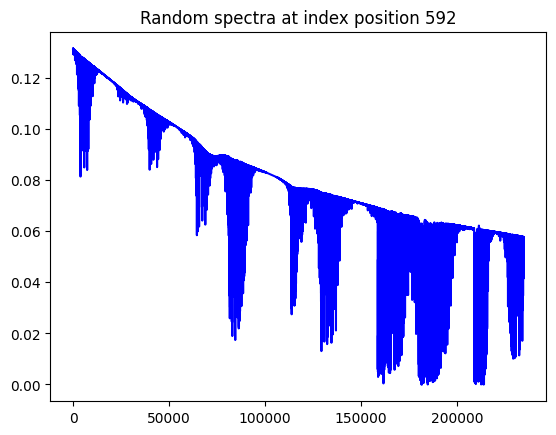

In [232]:
plot_random_spectra(SA_corrected)

<h3>Save the corrected spherical albedo</h3>

In [234]:
def save_HDF5(Y, save_loc, file_name):
    """
    Saves the given NumPy array into the desired location in HDF5 format.
    
    Args:
        Y: NumPy array
        save_loc: the path to the desired saving location
        file_name: name of the saved file
        
    Returns:
        None.
    """
    full_path = save_loc + file_name
    with h5py.File(full_path, "w") as hf:
        hf.create_dataset("output_data", data=Y)

In [235]:
save_loc = "/fmi/projappl/project_2001985/jamin/data/libradtran_data/NN_data/"
file_name = "spherical_albedo_corrected.h5"
save_HDF5(Y=SA_corrected, save_loc=save_loc, file_name=file_name)